<a href="https://colab.research.google.com/github/davidtweedle/elliptic-curve-data-science/blob/main/cond_50k_rescaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rescaling average aps by conductor for elliptic curves with conductor from 1 to 50000.
----------------------------------------------------------------------------------------------------------------------------------
We will now take the curves with conductor in the range 1 to 50000 (obtained from the LMFDB).
Let's tabulate the average ap's when they are binned according to the value of $p/c$ where $c$ is the conductor
of the elliptic curve.
We will see that the murmurations over a large range of conductors develop in an interesting way.
Our datasets are labelled "cond_50k_i.data" where i is an integer ranging from 1 to 14.
The primes $p$ we consider are in the range 1 to 50000.

In [15]:
import os
using_colab = 'COLAB_GPU' in os.environ

In [16]:
if using_colab:
  !pip install -q ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

In [17]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.animation as animation
%matplotlib widget

In [18]:
if using_colab:
  def display_murmuration(ec,scale,primes,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    t = primes.astype(int)*scale;
    ax[0].plot(t,ec.loc[ec['rank']==1,primes].mean(),'b.');
    ax[1].plot(t,ec.loc[ec['rank']==-1,primes].mean(),'r.');
    ax[2].plot(t,ec[primes].mul(ec['rank'],axis=0).mean(),'c.');
    ax[0].set_title(title+", even rank");
    ax[1].set_title(title+", odd rank");
    ax[2].set_title(title+", combined ranks");

  def bin_murmuration(ec:pd.DataFrame, primes:pd.Index, x):
    n = len(x)
    idx = np.digitize(np.outer(np.reciprocal(1.0*ec['conductor']),primes.astype(float)),x)
    counts = np.zeros(shape=x.shape)
    sum_aps = np.zeros(shape=x.shape)
    for i in range(n):
      where = np.equal(idx,i)
      counts[i] = where.sum()
      sum_aps[i] = ec[primes].to_numpy()[where].sum()
    return sum_aps,counts

  def display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,title,ax,xlim=None,ylim=None):
    for axis in ax:
      axis.clear();
      if xlim:
        axis.set_xlim(*xlim)
      if ylim:
        axis.set_ylim(*ylim)
    ax[0].plot(x,sum_aps_even/counts_even,'b.');
    ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
    ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');
    ax[0].set_title(title+", even");
    ax[1].set_title(title+", odd");
    ax[2].set_title(title+", combined ranks");
else:
  from pyscript.murmur_from_dataframe import display_murmuration, display_rescaled_murmuration, bin_murmuration

In [19]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from googleapiclient.http import MediaIoBaseDownload

fileIds = {"cond_50k_1.data": "1--DhqVfpUd81e4pCszLVBHQC4_UsFDji",
           "cond_50k_2.data": "1-5AIZgRooTsr_7WYEGVWe3ly91oSTucQ",
           "cond_50k_3.data": "1-9NPTqXtKE1NfiR282sXMn0yut3PZskW",
           "cond_50k_4.data": "1-BouL17saPf3VF0yTSsmxU7O1Oao8Px6",
           "cond_50k_5.data": "1-E0uPPl4vWACeFaJD0Vz6DgPBAKjGjn9",
           "cond_50k_6.data": "1-EdkpjtDIazFMJ94-Dq1qCT-Mgirhqin",
           "cond_50k_7.data": "1-RYVXJVXh6c6Bt5uaOrojXvV1G3xdft7",
           "cond_50k_8.data": "1-TRqQlS3-TgEirKK4grbw8XdclM6JpgI",
           "cond_50k_9.data": "1-UwJmRCZuERD4Jr61o5mQ9kXRvprFbyk",
           "cond_50k_10.data": "1-_Nc-AQ0F_4ykYASwlstoqefezLPhrhy",
           "cond_50k_11.data": "1-mBJG6AyhCm5aWIt7H6c6naKfk2Ud2gh",
           "cond_50k_12.data": "1-pYJj4pmCAZ3GPkyTydr2iIJLa44LKC6",
           "cond_50k_13.data": "1-s6Eiy3YjltaopNcvcphBUx3KdkwZSiR",
           "cond_50k_14.data": "1-tyr0epyOZp_6h9ylUK5eGUNe0NXUiR2"
}

def load_file(fileId, index_col, using_colab=True):
  file_link = None
  if using_colab:
    request = drive_service.files().get_media(fileId=fileId)
    file_link = io.BytesIO()
    downloader = MediaIoBaseDownload(file_link, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    file_link.seek(0)
  else:
    file_link="data/" + fileId
  datatype = {index_col: np.dtype('str'),'discriminant':np.dtype('O')}
  datatype.setdefault(np.dtype('int64'))
  res = pd.read_csv(file_link,
                    delimiter=" ",
                    index_col=index_col,
                    usecols=lambda x: x!='discriminant',
                    dtype=datatype
  )
  if using_colab:
    file_link.close()
  return res

In [20]:
files = ["cond_50k_"+str(i)+".data" for i in range(1,15)]

In [21]:
ec = load_file(fileId=fileIds[files[0]], using_colab=using_colab, index_col="label")
ec.head()

,conductor,rank,2,3,5,7,11,13,17,19,...,49919,49921,49927,49937,49939,49943,49957,49991,49993,49999
label,,,,,,,,,,,,,,,,,,,,,
11.a1,11,0,-2,-1,1,-2,1,4,-2,0,...,-80,-53,148,248,-60,-336,-262,-58,134,20
11.a2,11,0,-2,-1,1,-2,1,4,-2,0,...,-80,-53,148,248,-60,-336,-262,-58,134,20
11.a3,11,0,-2,-1,1,-2,1,4,-2,0,...,-80,-53,148,248,-60,-336,-262,-58,134,20
14.a1,14,0,-1,-2,0,1,0,-4,6,2,...,144,206,-4,294,-316,60,332,-24,206,-256
14.a2,14,0,-1,-2,0,1,0,-4,6,2,...,144,206,-4,294,-316,60,332,-24,206,-256


In [22]:
primes = ec.columns[2:];
N,n = 2,1000;
x = np.linspace(1.0/n,N,n)
sumaps_0,counts_0 = bin_murmuration(ec[ec['rank']%2==0],primes,x);
sumaps_1,counts_1 = bin_murmuration(ec[ec['rank']%2==1],primes,x);

I start by binning each row according to the value of $p/c$ where $p$ is the prime (corresponding to columns) and $c$ is the conductor of the elliptic curve.
I split the interval from 0 to 2 into 1000 bins.
Above, I have started the process on the first file.
Below the process continues for each other file, tabulating the results for even rank and odd rank separately.
It can be time consuming depending on your hardware.

In [24]:
x_vec_even = [None for _ in range(14)];
sum_aps_vec_even = [None for _ in range(14)];
counts_vec_even = [None for _ in range(14)]
x_vec_odd = [None for _ in range(14)];
sum_aps_vec_odd = [None for _ in range(14)];
counts_vec_odd = [None for _ in range(14)];
sum_aps_vec_even[0] = sumaps_0;
counts_vec_even[0] = counts_0;
sum_aps_vec_odd[0] = sumaps_1;
counts_vec_odd[0] = counts_1;
for i in range(1,14):
    ec = load_file(fileId=fileIds[files[i]], using_colab=using_colab, index_col='label')
    ec_odd = ec[ec['rank']%2==1];
    ec = ec[ec['rank']%2==0];
    sum_aps_odd,counts_odd = bin_murmuration(ec_odd,primes,x);
    sum_aps_even,counts_even = bin_murmuration(ec,primes,x);
    sum_aps_vec_even[i] = sum_aps_even;
    counts_vec_even[i] = counts_even;
    sum_aps_vec_odd[i] = sum_aps_odd;
    counts_vec_odd[i] = counts_odd;

<ipython-input-18-be0ce8c27cc9>:35: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(x,sum_aps_even/counts_even,'b.');
<ipython-input-18-be0ce8c27cc9>:36: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
<ipython-input-18-be0ce8c27cc9>:37: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');


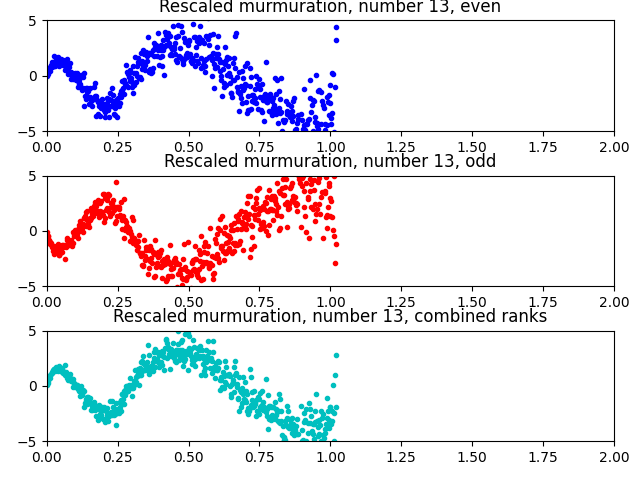

In [25]:
from matplotlib import rc
rc('animation', html='jshtml')
fig, ax = subplots(3);
fig.tight_layout()
ylim = (-5,5)
xlim = (0,2)
def update_plot(i):
    display_rescaled_murmuration(x,sum_aps_vec_even[i],counts_vec_even[i],\
                                 sum_aps_vec_odd[i],counts_vec_odd[i],"Rescaled murmuration, number "+str(i),ax,xlim,ylim);
anim= animation.FuncAnimation(fig,update_plot,14,interval=1000);
anim

Above, there is an animation designed to show the similarity of murmurations across different conductor ranges (once everything has been rescaled). The animation is saved below. If you want to see it in the notebook, you may need to add
``` %matplotlib widget ```
to get it to show properly.

In [26]:
## anim.save("media/rescaled_cond_50000.mp4")

Now, let's combine all the plots we produced above. Everything converges quite nicely.

In [27]:
combined_sum_aps_odd = [None for _ in range(14)];
combined_sum_aps_even = [None for _ in range(14)];
combined_counts_odd = [None for _ in range(14)];
combined_counts_even = [None for _ in range(14)];
combined_sum_aps_odd[0] = sum_aps_vec_odd[0];
combined_sum_aps_even[0] = sum_aps_vec_even[0];
combined_counts_odd[0] = counts_vec_odd[0];
combined_counts_even[0] = counts_vec_even[0];
for i in range(1,14):
    combined_sum_aps_odd[i] = combined_sum_aps_odd[i-1] + sum_aps_vec_odd[i];
    combined_counts_odd[i] = combined_counts_odd[i-1] + counts_vec_odd[i];
    combined_sum_aps_even[i] = combined_sum_aps_even[i-1]+ sum_aps_vec_even[i];
    combined_counts_even[i] = combined_counts_even[i-1]+ counts_vec_even[i];

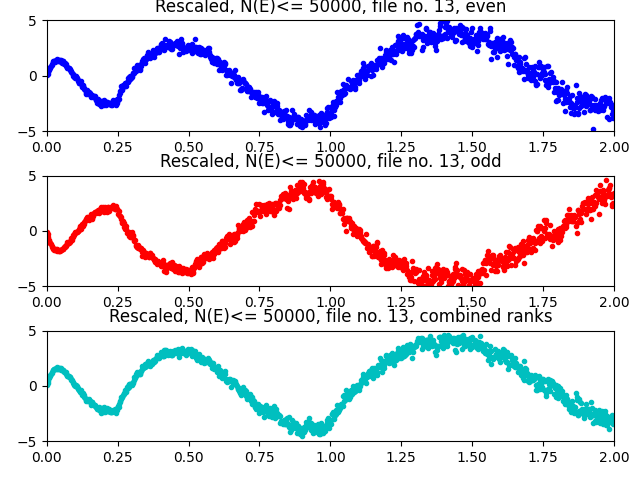

In [28]:
fig2,ax2 = subplots(3);
fig2.tight_layout();
ylim = (-5,5)
xlim = (0,2)
def update_plot(i):
    display_rescaled_murmuration(x,combined_sum_aps_even[i],combined_counts_even[i],\
                               combined_sum_aps_odd[i],combined_counts_odd[i],"Rescaled, N(E)<= 50000, file no. "+str(i),ax2,xlim,ylim)
anim2 = animation.FuncAnimation(fig2,update_plot,14,interval=1000);
anim2

In [29]:
## anim2.save("media/running_averages_cond_50000.mp4")

We have saved the resulting animation. Notice the final plot has quite a few interesting features.